<h2><center>Домашняя работа: Методы обучения без учителя</center></h2>
<hr>
<h2><center>Железцов Н. ML-12</center></h2>

In [4]:
%matplotlib inline

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [6]:
# Загружаем данные сенсоров
sign_database_url = 'https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture04/data/sign_database.csv'
df_database = pd.read_csv(sign_database_url)

# Загружаем метки классов
sign_classes_url = 'https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture04/data/sign_classes.csv'
sign_classes = pd.read_csv(sign_classes_url, index_col=0, header=0, names=['id', 'class'])

In [7]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

x_l       x_r       y_l       y_r  ...  little_l  little_r  id  time
0 -0.097816 -0.127761 -0.029051  0.537977  ...       0.0  0.133088   0     0
1 -0.102460 -0.126734 -0.029230  0.537758  ...       0.0  0.084865   0     1
2 -0.103085 -0.125618 -0.028605  0.537464  ...       0.0  0.026230   0     2
3 -0.102639 -0.126020 -0.028873  0.537306  ...       0.0  0.015033   0     3
4 -0.105139 -0.127538 -0.028917  0.537513  ...       0.0  0.000815   0     4

[5 rows x 24 columns]

In [8]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

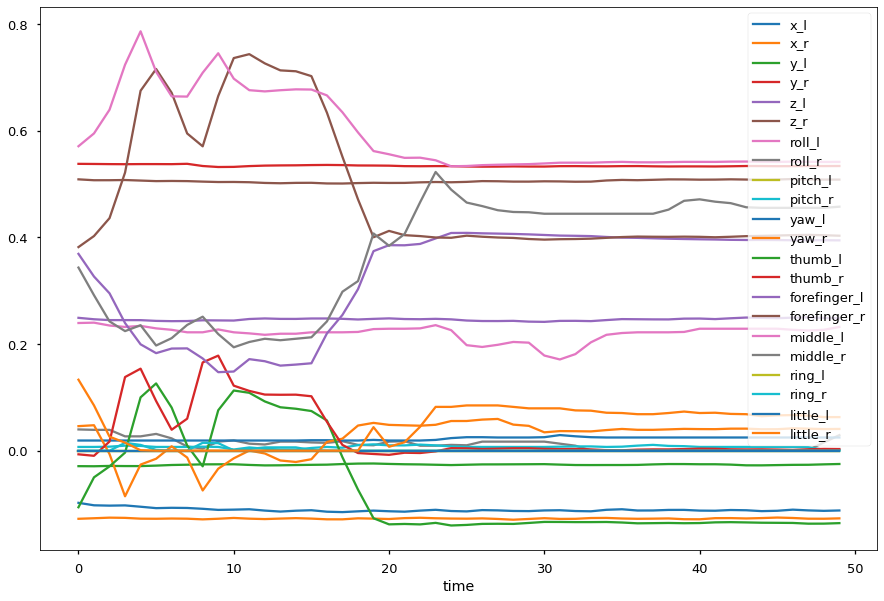

In [9]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [12]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz

--2021-11-21 20:08:25--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2021-11-21 20:08:25--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37ff8e99cc1fa446ddea3c3f8e.dl.dropboxusercontent.com/cd/0/inline/BaayWUhLlgk0GWLTDK_P6URrHBq5BICxVMmmKM7Zz2FLbVSc85vsjfl-4L3FWfw0uNoJdvMRh1XGMlHJmSS9kafX9UWVZcdx6hJLwqCS4Zh6rjVviiMRsWoYcQ0zASvukpmxr57peAYnyoHJacm3ALv8/file# [following]
--2021-11-21 20:08:26--  https://uc37ff8e99cc1fa446ddea3c3f8e.dl.dropboxusercontent.com/cd/0/inline/BaayWUhLlgk0GWLTDK_P6URrHBq5BICxVMmmK

In [13]:
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)
sign_features_filtered.shape

(2565, 11517)

In [14]:
sign_features_filtered.head()

Unnamed: 0  ...  y_l__symmetry_looking__r_0.35000000000000003
0           0  ...                                           1.0
1           1  ...                                           1.0
2           2  ...                                           1.0
3           3  ...                                           1.0
4           4  ...                                           1.0

[5 rows x 11517 columns]

## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [16]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes['class'].values

In [17]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

In [18]:
base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
base_cv_scores.mean()

0.9196881091617932

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

Найдем наименьшее количество главных компонент, при которых качество
превысит 90%

Закомментированная ячейка выполняется невероятно долго (порядка 2 часов в моем случае), поэтому необходимые значения сохранил в файлы для воспроизводимости результата

In [19]:
# from numpy.linalg import eig
#
# X_scale = StandardScaler().fit_transform(X)
# C = X_scale.T @ X_scale
# lmdb, W = eig(C)
#
# with open('lmdb.npy', 'wb') as file_lmdb:
#     np.save(file_lmdb, lmdb)
#    
# with open('W.npy', 'wb') as file_w:
#     np.save(file_w, W)

In [21]:
!wget https://github.com/NikZheleztsov/HW_4/blob/master/lmdb.npy?raw=true -O ./data/lmdb.npy

with open('./data/lmdb.npy', 'rb') as file_lmdb:
    lmdb_from_file = np.load(file_lmdb)

x_plot = range(sign_features_filtered.shape[1])
y_plot = np.cumsum((lmdb_from_file) / np.sum(lmdb_from_file))

--2021-11-21 20:11:29--  https://github.com/NikZheleztsov/HW_4/blob/master/lmdb.npy?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NikZheleztsov/HW_4/raw/master/lmdb.npy [following]
--2021-11-21 20:11:29--  https://github.com/NikZheleztsov/HW_4/raw/master/lmdb.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NikZheleztsov/HW_4/master/lmdb.npy [following]
--2021-11-21 20:11:29--  https://raw.githubusercontent.com/NikZheleztsov/HW_4/master/lmdb.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184400 (180K

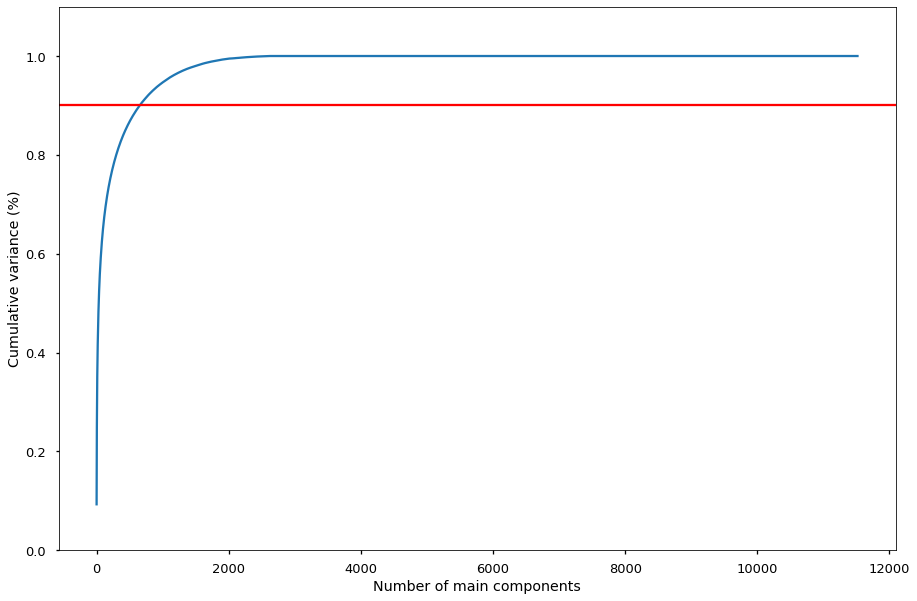

In [22]:
import warnings
warnings.filterwarnings('ignore')

# Нарисуем график зависимости дисперсии от числа компонент
plt.plot(x_plot, y_plot)
plt.xlabel('Number of main components')
plt.ylabel('Cumulative variance (%)')
plt.axhline(y = 0.9, color = 'r')
plt.ylim(0.0, 1.1)
plt.show()

In [23]:
for idx, y in enumerate(y_plot):
    if y > 0.9:
        min_n = x_plot[idx]
        print(f'Наименьшее число параметров: {min_n}')
        break

Наименьшее число параметров: 653


In [ ]:
from sklearn.decomposition import PCA

pca_step = ['PCA_step', PCA(n_components = min_n, svd_solver='randomized', random_state=123)]
base_model.steps.insert(1, pca_step)

In [ ]:
# Около 10 мин
pca_cv_scores = cross_val_score(base_model, X, y, cv=cv, \
                                scoring='accuracy', n_jobs = -1)
pca_cv_scores.mean()

0.917738791423002

Как и ожидалось, качество нового пайплайна превышает 90 %

Доли объясненной дисперсии уже фактически посчитаны, поэтому не вижу смысла обучать PCA на всех данных (это займет еще 2 часа)). explained_variance_ratio_ для полностью обученной PCA вернет:

In [24]:
explained_variance_ratio_ = \
    np.asarray((lmdb_from_file / np.sum(lmdb_from_file)), float)

explained_variance_ratio_

array([ 9.28750579e-02,  6.39568873e-02,  3.44203643e-02, ...,
        6.54247796e-35,  6.54247796e-35, -3.08146110e-36])

In [25]:
np.cumsum(explained_variance_ratio_[:654])[-1]

0.9000853646097077

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [26]:
news_url = 'https://raw.githubusercontent.com/vadim0912/MLIntro2021/main/lecture06/data/news.csv'
df = pd.read_csv(news_url, encoding='utf8')
df.head()

text  ...                   class
0   В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...  ...  Внутренняя политика РФ
1   Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...  ...  Внутренняя политика РФ
2   Аргументы и Факты (aif.ru), Москва, 14 января...  ...  Внутренняя политика РФ
3   Google Новости ТОП, Москва, 14 января 2017 АК...  ...  Внутренняя политика РФ
4   Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...  ...  Внутренняя политика РФ

[5 rows x 4 columns]

In [27]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Спорт                                            100
Проишествия  РФ                                  100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [28]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [29]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [34]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

In [36]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2021-11-21 20:13:33--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.242, 5.45.205.243, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.242|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-11-21 20:13:33--  http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)... 5.45.205.221, 2a02:6b8::3:221
Connecting to cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)|5.45.205.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  15.70M  9

In [37]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 4 s, sys: 253 ms, total: 4.26 s
Wall time: 30.9 s


In [38]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [39]:
df.text[0] # так выгладит первая статья после предобработки

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [40]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [41]:
vect = TfidfVectorizer()
texts = df.text.values

In [42]:
vect_texts = vect.fit_transform(texts)
S = pairwise_distances(vect_texts, metric='cosine')

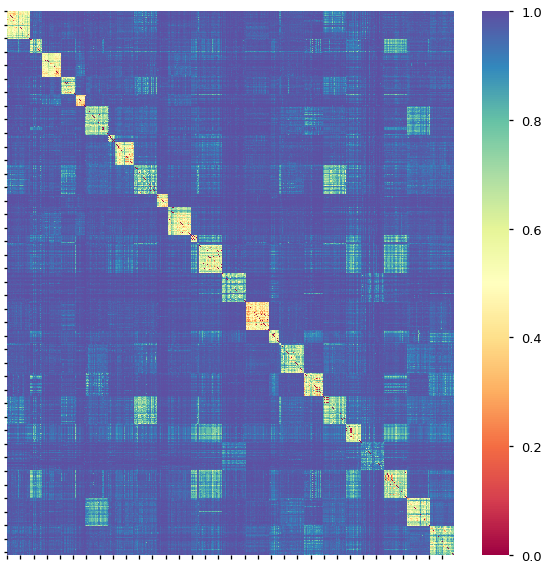

In [43]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.show()

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести (так и есть). 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

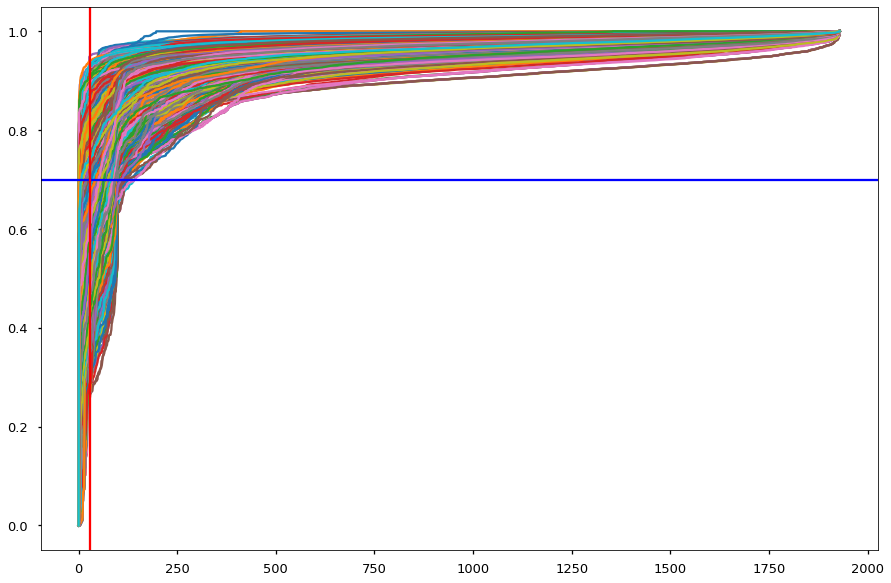

In [44]:
S_sorted = np.sort(S, axis = 0)
plt.plot(range(1930), S_sorted)
plt.axhline(y = 0.7, color = 'b')
plt.axvline(x = 30, color = 'r')
plt.show()

После расстояния 0.7 число выбросовых элементов резко возрастает. Нужно подбирать значения расстояния, находящиеся около 0.7, и min_samples от 30, судя по графику

In [45]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
dbscan = DBSCAN(eps=0.65, min_samples=35, \
                metric='precomputed', n_jobs=-1).fit(S)

labels = dbscan.labels_
unique, counts = np.unique(labels, return_counts=True)
print((np.asarray((unique, counts))))

[[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
 [286  99 385  84  61  41 192  81 154  49  99  65 100  42  98  94]]


In [ ]:
import random as rd

for cluster_label in unique:
    if cluster_label != -1:
        rd.seed(123)
        print (f'==== Cluster {cluster_label} ====')
        rand_text = rd.choices(texts[labels == cluster_label], k = 2)
        print(rand_text[0], '\n=================\n', rand_text[1])
        

==== Cluster 0 ====
москва январь петербуржец протестовать против передача церковь исаакиевский храм вечер вторник утро среда петиция против передача исаакиевский храм северный столица русский православный церковь подписывать менее х человек докладывать рамблер новость ссылаться служба один дело однако служба вестись думать нужный какой остальной мера объявлять депутат автор петиция располагать сайт обращаться георгий полтавченко владимир путин просьба останавливать передача храм основной мысль петербуржец хотеть доносить касаться передача этот монумент ограничивать открытый доступ житель турист посещение данный храм необходимо собирать подпись январь противник передача исаакиевский собор церковь проводить протестный акция ступень храм пройти формат встреча депутат январь губернатор санкт петербург георгий полтавченко проинформировать решение передавать исакиевский храм использование русский православный церковь сохранение немой музей петиция против передача исаакиевский собор рпц ночь

0. Внутренняя политика
1. Международные отношения
2. Смерть Чуркина (без понятия, куда отнести)
3. Оппозиция (расследования фбк)
4. Мировые события
5. Теракты
6. Криминальная хроника
7. Оппозиция (митинги)
8. Технологии
9. Культура
10. Спорт
11. Внутреняя политика (курорты, отдых россиян)
12. Мировые события (Франция)
13. Происшествия РФ
14. Внутренняя политика (выборы в РФ)

In [ ]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0                                          -1    0    1    2    3    4   \
class                                                                         
Важные мировые события                          20    0  216   84    0   41   
Внутренняя политика РФ                           9   99   62    0    0    0   
Внутренняя политика РФ: оппозиция               62    0    0    0   61    0   
Внутренняя политика: культура                    1    0    0    0    0    0   
Международные отношения                         48    0  105    0    0    0   
Международные отношения: Криминальная хроника    1    0    0    0    0    0   
Проишествия  РФ                                  2    0    0    0    0    0   
Спорт                                          100    0    0    0    0    0   
Спорт                                           37    0    0    0    0    0   
Теракты                                          6    0    2    0    0    0   
Технологии                                       0    0    0    0    0    0   

col_0                                           5    6    7    8    9    10  \
class                                                                         
Важные мировые события                           0    0    0    0    0    0   
Внутренняя политика РФ                           0    0    0    0    0    0   
Внутренняя политика РФ: оппозиция                0    0  154    0    0    0   
Внутренняя политика: культура                    0    0    0    0   99    0   
Международные отношения                          0    0    0    0    0    0   
Международные отношения: Криминальная хроника    0   81    0    0    0    0   
Проишествия  РФ                                  0    0    0    0    0    0   
Спорт                                            0    0    0    0    0    0   
Спорт                                            0    0    0    0    0   65   
Теракты                                        192    0    0    0    0    0   
Технологии                                       0    0    0   49    0    0   

col_0                                           11   12   13   14  
class                                                              
Важные мировые события                           0   42    0    0  
Внутренняя политика РФ                         100    0    0   94  
Внутренняя политика РФ: оппозиция                0    0    0    0  
Внутренняя политика: культура                    0    0    0    0  
Международные отношения                          0    0    0    0  
Международные отношения: Криминальная хроника    0    0    0    0  
Проишествия  РФ                                  0    0   98    0  
Спорт                                            0    0    0    0  
Спорт                                            0    0    0    0  
Теракты                                          0    0    0    0  
Технологии                                       0    0    0    0

In [ ]:
adjusted_rand_score(df.loc[:, 'class'], labels)

0.44251863803948227

Найдем лучший из возможных вариантов

In [ ]:
from tqdm import tqdm

max_score, best_eps, best_num = 0, 0, 0

for eps in tqdm(range(1, 100)):
    for min_s in range(300):
        dbscan = DBSCAN(eps=eps / 100, min_samples=min_s, \
                metric='precomputed', n_jobs=-1).fit(S)
        
        labels = dbscan.labels_
        score = adjusted_rand_score(df.loc[:, 'class'], labels)
        if score > max_score:
            max_score = score
            best_eps = eps
            best_num = min_s

100%|█████████████████████████████████████████████████████████████████| 99/99 [11:52<00:00,  7.19s/it]


In [ ]:
print(f'Best score: {max_score}')
print(f'Best eps: {best_eps / 100}')
print(f'Best min_samples: {best_num}')

Best score: 0.47088944318424647
Best eps: 0.67
Best min_samples: 39


Наша оценка близка к наилучшему из возможных вариантов кластеризации. Хотя она иногда разделяет статьи по чересчур узким категориям (курорты, выборы в РФ и др)